In [1]:
from diffusion_curvature.core import *
from fastcore.all import *

# Diffusion Curvature Core (Pyg)
> Where the sausage is made

This notebook establishes the core of the diffusion curvature library. 
Our implementation is structured around the `ManifoldGraph` class, which stores all of the relevant information for our geometric analysis. 
Below this, we define various transforms on the manifold graph:
1. Powering the diffusion matrix
2. Computing Heat Geodesic Distances
3. Computing the wasserstein spread of diffusino
among others.

When convenient, we define each transform directly within this notebook. For some transforms, extra implementation is needed; we source those to other notebooks.

TODOs:
- Make the ManifoldGraph class a subclass of torch_geometric's data.
- Transition from numpy to torch

In this implementation, we define `ManifoldGraph` as a subclass of Pytorch Geometric's standard graph object. This has a number of pleasant benefits:
- It scales to much larger graphs: PyG uses a native sparse format. This allows diffusing over thousands of nodes, without any loss of fidelity.
- It inherits gpu compatibility

In [116]:
from fastcore.all import *
from diffusion_curvature.core import *
import torch_geometric
class ManifoldGraph(torch_geometric.data.Data):
    """
    Class for Manifold Graphs. Stores the basic graph information used for geometric analysis: 
    A (the affinity/adjacency matrix), P (the diffusion matrix), P^t (the powered diffusion matrix), and D (the manifold distance matrix)
    Takes raw points, X. Can also optionally pass in any of the above to save the trouble of recomputing it.
    """
    def __init__(self, 
    coords=None, # raw points
    dimension=None, # dimension of manifold. 
    kernel_type:str = "adaptive", # "fixed" or "adaptive"
    anisotropic_density_normalization:float=0.5,  # normalize out this amount of the density. 0 is none. 1 is all.
    num_neighbors = 10, # for adaptive kernel, constructs graph to connect this number of neighbors
    t = 10, # steps of diffusion
    A = None, 
    P = None, 
    Pt = None, 
    D = None, 
    *kw_args
    ):
        """
        We compute the affinity matrix and diffusion matrix automatically
        """
        self.node_attributes = {}
        store_attr()
        if not self.A:
            self.A = gaussian_kernel(self.X, kernel_type=self.kernel_type, k = self.num_neighbors, anisotropic_density_normalization=self.anisotropic_density_normalization)
            np.fill_diagonal(self.A,0)
            
        if not self.P:
            self.P = compute_anisotropic_diffusion_matrix_from_graph(self.A, self.anisotropic_density_normalization)        
    def num_nodes(self):
        return len(self.A)

In [117]:
import numpy as np
def power_diffusion_matrix(G:ManifoldGraph, t:int=None):
    # Raises the diffusion matrix to t
    if not t:
        t = G.t
    G.Pt = np.linalg.matrix_power(G.P, t)
    return G


## PHATE Distances

Wasserstein Diffusion Curvature -- despite the name -- requires only manifold distances. This saves quite a bit of computation, but doesn't alleviate the need for a good approximation of the manifold's geodesic distance. Here, we implement one straightforward and accurate manifold distance: that proposed by Moon et al. in PHATE (2019). The PHATE distance is an extension of the diffusion distance, except instead of calculating the L2 distances between diffusion coordinates (which corresponds roughly to the rows of the diffusion matrix), it takes the L2 distances between the log-transformed diffusions. This flips the weighting from local to global, as a diffusion that assigns a small mass where another assigns a miniscule mass becomes much further than those that differ only at their centers. This log transform has the additional advantage of, through the WAWA formulation of the heat equation, recovering the distance term.

It is defined as:
$$d_p(x,y) = \| \log(p_y^t)-\log(p_x^t) \|_2 $$

In [118]:
from sklearn.metrics import pairwise_distances
import numpy as np
@Transform
def phate_distances(G:ManifoldGraph):
    assert G.Pt is not None
    log_Pts = -np.log(G.Pt + 1e-6)
    D = pairwise_distances(log_Pts)
    G.D = D
    return G

# The Wasserstein Diffusion Curvature
This has two components: computing the spread of diffusion, and computing a "flattened facsimile" of the graph. 

For the second, we presently give a naive implementation that presumes the dimensionality is known and constructs random noise of the same dimension and size.

In [119]:
def wasserstein_spread_of_diffusion(G:ManifoldGraph, idx = None):
    """
    Returns how "spread out" each diffusion is, with wasserstein distance"
    Presumes that the manifold distances have been separately calculated
    If idx is passed, only computes wsd at that index
    """
    assert G.Pt is not None
    assert G.D is not None
    # G.P is our distribution on each node. We compute the sum of the distances each bit of "diffusion mass" has to be carried 
    # back to the center
    if idx is None:
        return np.sum(G.D * G.Pt, axis=1)
    else:
        return np.sum(G.D[idx]* G.Pt[idx])

In [120]:
from scipy.stats import entropy
def entropy_of_diffusion(G:ManifoldGraph, idx=None):
    assert G.Pt is not None
    if idx is None:
        return entropy(G.Pt, axis=1)
    else:
        return entropy(G.Pt[idx])

In [121]:
def flattened_facsimile_of_graph(G:ManifoldGraph, dimension=None):
    if not dimension:
        dimension=G.dimension
    noise = np.concatenate([np.zeros((1,dimension)), 2*np.random.rand(G.num_nodes()-1,dimension)-1])
    # compute the adjacency matrix and P
    G_flat = ManifoldGraph(noise, kernel_type=G.kernel_type, num_neighbors=G.num_neighbors, anisotropic_density_normalization=G.anisotropic_density_normalization)
    G_flat = power_diffusion_matrix(G_flat, t = G.t)
    # TODO: This is a tad wasteful. We only need the center diffusion powered.
    return G_flat

In [122]:
@Transform
def wasserstein_diffusion_curvature(G:ManifoldGraph, t=None,):
    if t is None:
        t = G.t
    if G.Pt is None:
        G = power_diffusion_matrix(G,t)
    if G.D is None:
        G = phate_distances(G)
    spreads_on_manifold = wasserstein_spread_of_diffusion(G)
    # Create flattened version of manifold and compute stuff
    G_flat = flattened_facsimile_of_graph(G)
    G_flat = power_diffusion_matrix(G_flat)
    G_flat = phate_distances(G_flat)
    spreads_on_flat = wasserstein_spread_of_diffusion(G_flat, idx=0)
    print(spreads_on_flat)
    G.node_attributes['curvature'] = spreads_on_flat - spreads_on_manifold #1 - (spreads_on_manifold/spreads_on_flat)
    return G

In [123]:
@Transform
def pointwise_ricci_curvature(G:ManifoldGraph, t=None,):
    if t is None:
        t = G.t
    if G.Pt is None:
        G = power_diffusion_matrix(G,t)
    if G.D is None:
        G = phate_distances(G)
    spreads_on_manifold = wasserstein_spread_of_diffusion(G)
    # Create flattened version of manifold and compute stuff
    G_flat = flattened_facsimile_of_graph(G)
    G_flat = power_diffusion_matrix(G_flat)
    G_flat = phate_distances(G_flat)
    spreads_on_flat = wasserstein_spread_of_diffusion(G_flat, idx=0)
    print(spreads_on_flat)
    G.node_attributes['curvature'] = 1 - (spreads_on_manifold/(spreads_on_flat))
    return G

In [124]:
@Transform
def diffusion_entropy_curvature(G:ManifoldGraph, t=None,):
    if t is None:
        t = G.t
    if G.Pt is None:
        G = power_diffusion_matrix(G,t)
    spreads_on_manifold = entropy_of_diffusion(G)
    # Create flattened version of manifold and compute stuff
    G_flat = flattened_facsimile_of_graph(G)
    G_flat = power_diffusion_matrix(G_flat)
    spreads_on_flat = entropy_of_diffusion(G_flat, idx=0)
    print(spreads_on_flat)
    G.node_attributes['curvature'] = spreads_on_flat - spreads_on_manifold
    return G

In [125]:
from diffusion_curvature.core import plot_3d
def plot_manifold_curvature(G:ManifoldGraph, title = None):
    X = G.X
    ks = G.node_attributes['curvature']
    plot_3d(X, ks, colorbar=True, title=title)

# Use on Data
To compute the wasserstein diffusion curvature of the data, first put the data into your `ManifoldGraph` object. Supply the dimension of the data, if you know it. Also select the parameters for creating an affinity matrix: the kernel type, the number of neighbors to use, and the degree of anisotropic density normalization.

If you're unsure what value to put for any of these, leave it blank. We'll use heuristics to find a good value for t and use our own dimension fitting to find a good value for that.

Alternately, if already have a graph (A), or any other piece of the puzzle, just supply it as an argument when initializing the `ManifoldGraph` class.

In [126]:
from diffusion_curvature.datasets import *
X_torus, k_torus_real = torus(n=4000)
print("num nodes", len(X_torus))

num nodes 2024


In [127]:
G_torus = ManifoldGraph(
    X = X_torus, 
    dimension= 2,
    t = 8,
    anisotropic_density_normalization=1,
    )

/home/piriac/mambaforge/envs/diffusion_curvature/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


77.14942444917283


/home/piriac/mambaforge/envs/diffusion_curvature/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


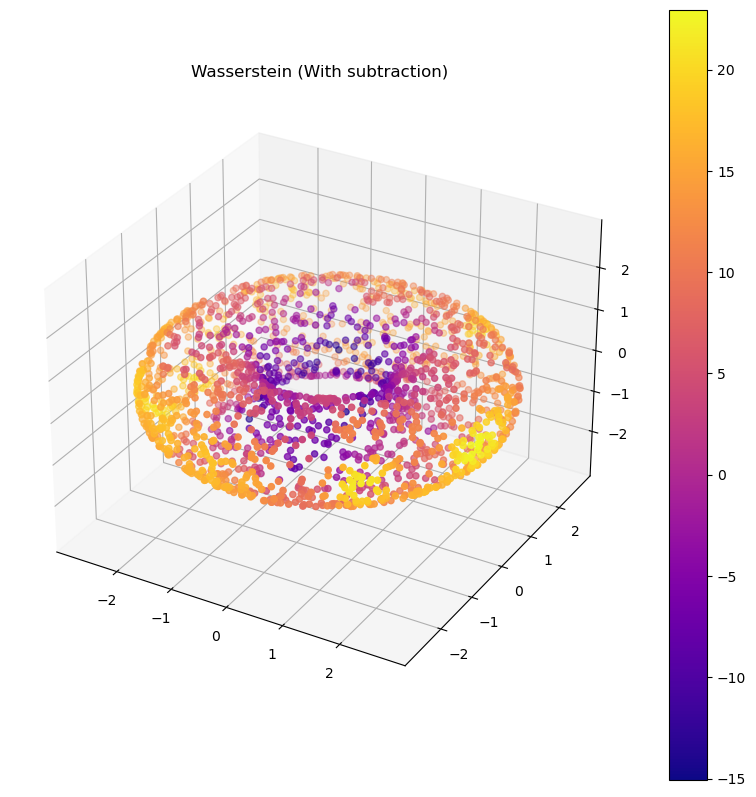

In [128]:
G_torus = wasserstein_diffusion_curvature(G_torus)
plot_manifold_curvature(G_torus, title="Wasserstein (With subtraction)")

81.50420495789342


/home/piriac/mambaforge/envs/diffusion_curvature/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


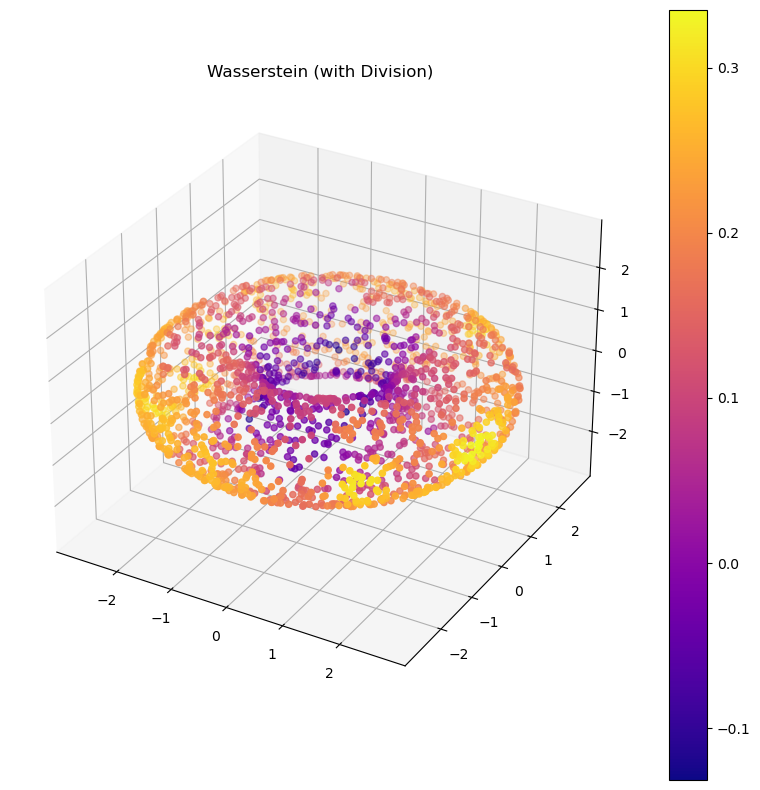

In [129]:
G_torus = pointwise_ricci_curvature(G_torus)
plot_manifold_curvature(G_torus, "Wasserstein (with Division)")

6.245391843724038


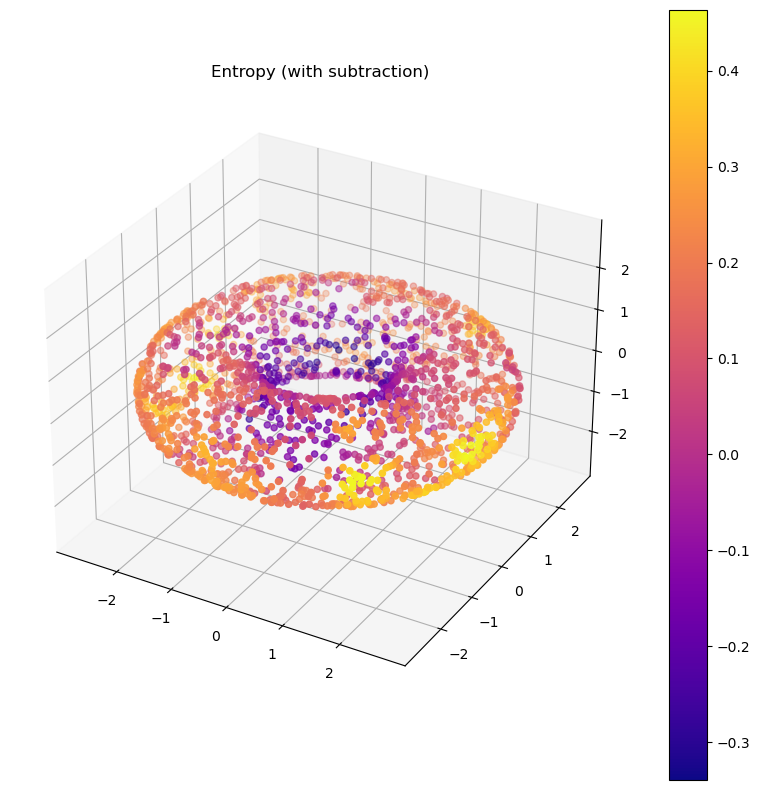

In [130]:
G_torus = diffusion_entropy_curvature(G_torus)
plot_manifold_curvature(G_torus, "Entropy (with subtraction)")

In [ ]:
k_torus_real